In [1]:
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Visualization function for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):  #可视化神经网络运行中间结果
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:  #可视化图
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()


In [2]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root="/tmp/ENZYMES",name='ENZYMES')

print(dataset)
print(len(dataset))
print(dataset.num_classes)
print(dataset.num_node_features)

Extracting \tmp\ENZYMES\ENZYMES\ENZYMES.zip
Processing...


ENZYMES(600)
600
6
3


Done!


In [3]:
data = dataset[0]

In [4]:
data.is_undirected()

True

In [9]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

Using existing file ind.cora.x
Using existing file ind.cora.tx
Using existing file ind.cora.allx
Processing...
Done!


In [10]:
print(len(dataset))

print(dataset.num_classes)

print(dataset.num_node_features)

1
7
1433


In [11]:
data = dataset[0]

print(data.is_undirected())

print(data.train_mask.sum().item())

print(data.val_mask.sum().item())

print(data.test_mask.sum().item())

True
140
500
1000


In [12]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [13]:
# 创建Data

import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

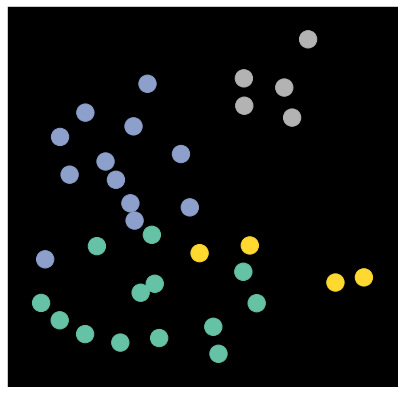

In [15]:
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
data = dataset[0]
G = to_networkx(data, to_undirected=True)

visualize(G, color=data.y)

In [16]:
# Mini-batch
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

for batch in loader:
    print(batch)
    print(batch.num_graphs)


DataBatch(edge_index=[2, 4120], x=[1094, 21], y=[32], batch=[1094], ptr=[33])
32
DataBatch(edge_index=[2, 4182], x=[1038, 21], y=[32], batch=[1038], ptr=[33])
32
DataBatch(edge_index=[2, 3900], x=[992, 21], y=[32], batch=[992], ptr=[33])
32
DataBatch(edge_index=[2, 3552], x=[984, 21], y=[32], batch=[984], ptr=[33])
32
DataBatch(edge_index=[2, 3880], x=[980, 21], y=[32], batch=[980], ptr=[33])
32
DataBatch(edge_index=[2, 4082], x=[1068, 21], y=[32], batch=[1068], ptr=[33])
32
DataBatch(edge_index=[2, 3612], x=[909, 21], y=[32], batch=[909], ptr=[33])
32
DataBatch(edge_index=[2, 3446], x=[987, 21], y=[32], batch=[987], ptr=[33])
32
DataBatch(edge_index=[2, 3986], x=[1049, 21], y=[32], batch=[1049], ptr=[33])
32
DataBatch(edge_index=[2, 4100], x=[1094, 21], y=[32], batch=[1094], ptr=[33])
32
DataBatch(edge_index=[2, 4096], x=[1049, 21], y=[32], batch=[1049], ptr=[33])
32
DataBatch(edge_index=[2, 4072], x=[1065, 21], y=[32], batch=[1065], ptr=[33])
32
DataBatch(edge_index=[2, 3892], x=[102

D:\anaconda3\envs\graph\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [17]:
# GNN
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)


GCN(
  (conv1): GCNConv(21, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=6, bias=True)
)


In [19]:
import time

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    # Visualize the node embeddings every 10 epochs
    # if epoch % 10 == 0:
    #     visualize(h, color=data.y, epoch=epoch, loss=loss)
    #     time.sleep(0.3)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (34x34 and 21x4)